# Exploring the Data

Let's start with importing the necessary libaries, reading in the data, and checking out the dataset.

Note that the last column from this dataset, 'income', will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import visualisation libraries
import visuals as vs
import seaborn as sns
import matplotlib.pyplot as plt

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset

census_data = pd.read_csv("census.csv")
# Success - Display the first record
display(census_data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


In [3]:
#datatypes display
census_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
age                45222 non-null int64
workclass          45222 non-null object
education_level    45222 non-null object
education-num      45222 non-null float64
marital-status     45222 non-null object
occupation         45222 non-null object
relationship       45222 non-null object
race               45222 non-null object
sex                45222 non-null object
capital-gain       45222 non-null float64
capital-loss       45222 non-null float64
hours-per-week     45222 non-null float64
native-country     45222 non-null object
income             45222 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


In [4]:
# Total number of records
n_records = len(census_data)

# Number of records where individuals income is more than $50,000
n_greater_50k = len(census_data[census_data['income'] == '>50K'])

# Number of records where individuals income is at most $50,000
n_at_most_50k = len(census_data[census_data['income'] == '<=50K'])

# Percentage of individuals whose income is more than $50,000
greater_percent = 100 * n_greater_50k / n_records

# Print the results
print ("Total number of records: {}".format(n_records))
print ("Individuals making more than $50,000: {}".format(n_greater_50k))
print ("Individuals making at most $50,000: {}".format(n_at_most_50k))
print ("Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


####  Breakdown of the counts of people earning above or below 50K based on their sex and education levels.

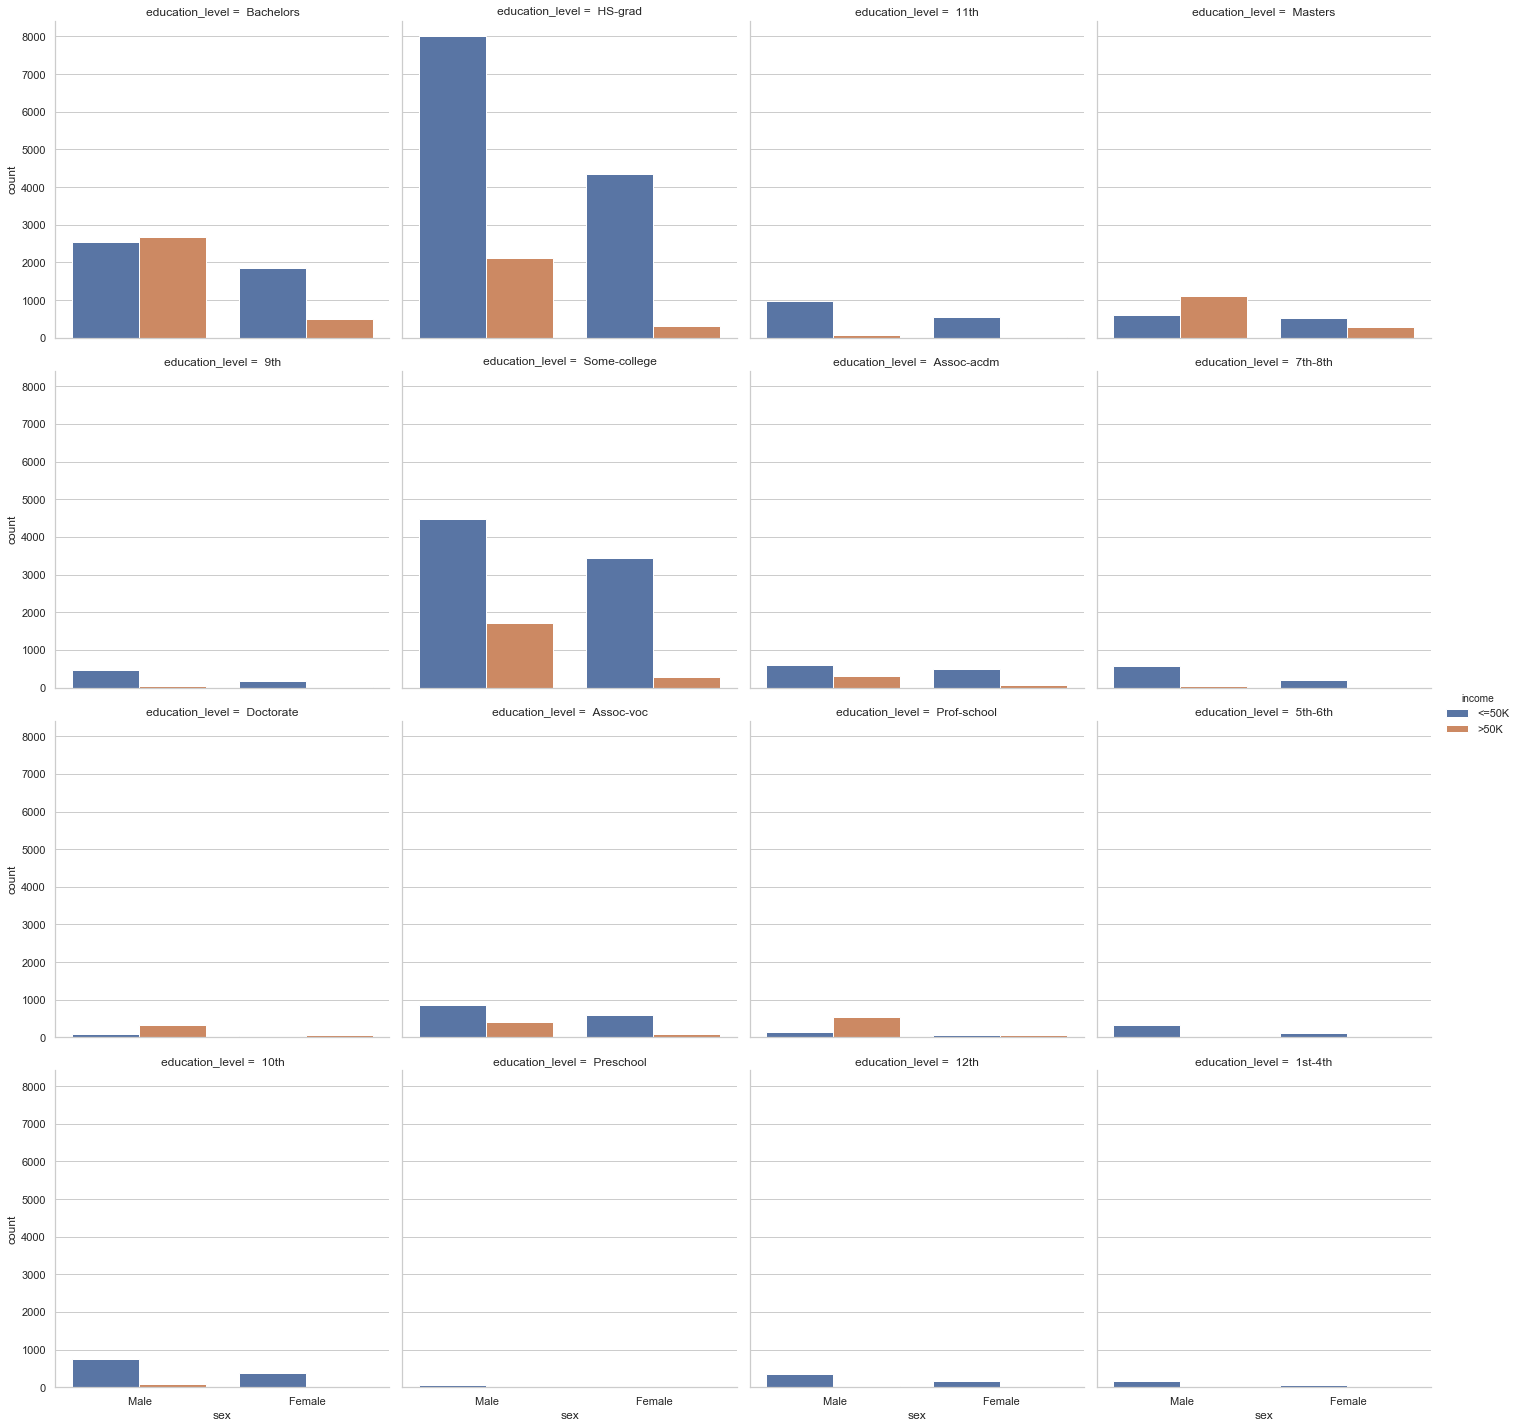

In [5]:
sns.set(style="whitegrid", color_codes=True)
sns.catplot("sex", col='education_level', data=census_data, hue='income', kind="count", col_wrap=4);

# Preparing the Data

C:\Users\sborra\Desktop\ds_portfolio\finding_donors_for_charity\visuals.py:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


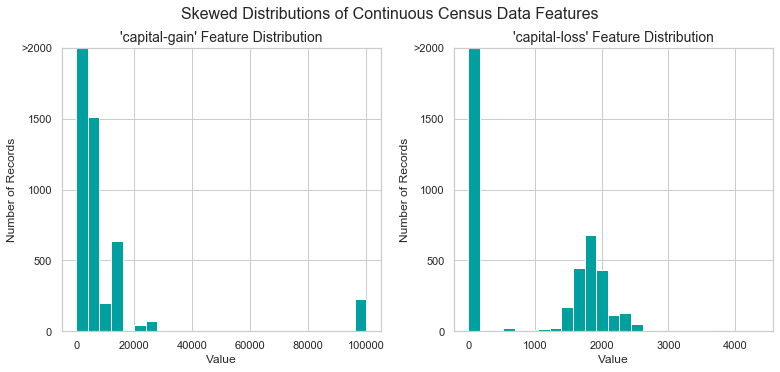

In [6]:
# Split the data into features and target label
income_raw = census_data['income']
features_raw = census_data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(census_data)

For highly-skewed feature distributions such as 'capital-gain' and 'capital-loss', it is common practice to apply a logarithmic transformation on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of 0 is undefined, so we must translate the values by a small amount above 0 to apply the the logarithm successfully.

C:\Users\sborra\Desktop\ds_portfolio\finding_donors_for_charity\visuals.py:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


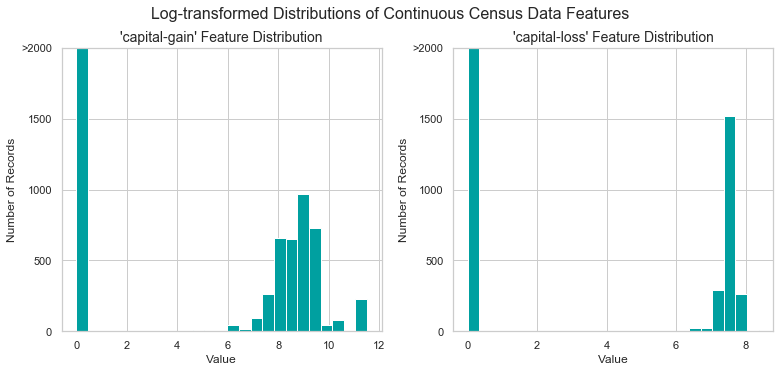

In [8]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as 'capital-gain' or 'capital-loss' above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

In [11]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 2))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.8,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States


### Data Preprocessing
From the table in Exploring the Data above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called categorical variables) be converted. One popular way to convert categorical variables is by using the one-hot encoding scheme. One-hot encoding creates a "dummy" variable for each possible category of each non-numeric feature.

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, 'income' to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as 0 and 1, respectively.

In [18]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x: 1 if x == '>50K' else 0)

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))


#print (encoded)

103 total features after one-hot encoding.


In [19]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


### Question 1 - Naive Predictor Performace
If we chose a model that always predicted an individual made more than $50,000, what would that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to 'accuracy' and 'fscore' to be used later.
Please note that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

In [21]:
# Calculate accuracy
accuracy = n_greater_50k / n_records

# Calculating precision
precision = n_greater_50k / (n_greater_50k + n_at_most_50k)

#Calculating recall
recall = n_greater_50k / (n_greater_50k + 0)

# Calculate F-score using the formula above for beta = 0.5
fscore =  (1  + (0.5*0.5)) * ( precision * recall / (( 0.5*0.5 * (precision))+ recall))

# Print the results 
print ("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


## Supervised Learning Models

### Model Application

#### 1) Decision Trees
#### 2) SVM
#### 3) Ensemble methods: AdaBoost

### Creating a Training and Predicting Pipeline

To properly evaluate the performance of each model we've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data.

In [22]:
# Import two metrics from sklearn - fbeta_score and accuracy_score

from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set,
    # then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,0.5)
        
    # Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test,predictions_test,0.5)
       
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Model Evaluation

Let's train and test the models on training sets of different sizes to see how it affects their runtime and predictive performance (both on the test, and training sets).

DecisionTreeClassifier trained on 362 samples.
DecisionTreeClassifier trained on 3618 samples.
DecisionTreeClassifier trained on 36177 samples.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC trained on 362 samples.
SVC trained on 3618 samples.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC trained on 36177 samples.
AdaBoostClassifier trained on 362 samples.
AdaBoostClassifier trained on 3618 samples.
AdaBoostClassifier trained on 36177 samples.


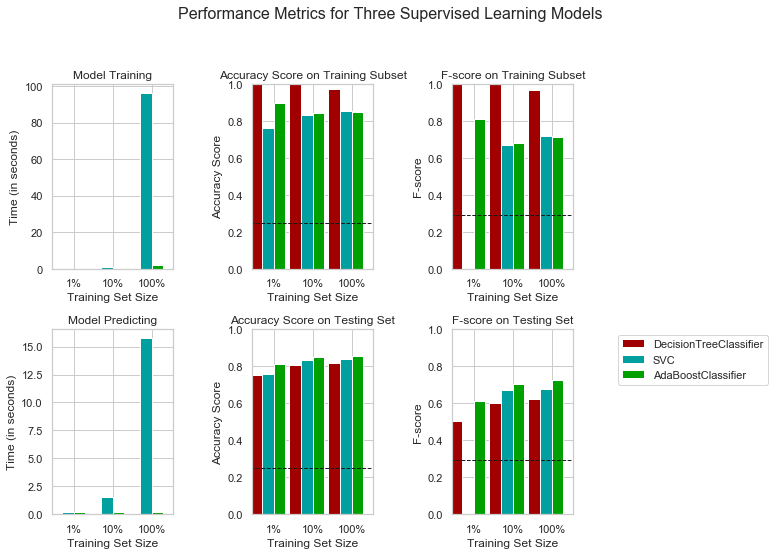

In [23]:
# Import the three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

# Initialize the three models, the random states are set to 101 so we know how to reproduce the model later
clf_A = DecisionTreeClassifier(random_state=101)
clf_B = SVC(random_state = 101)
clf_C = AdaBoostClassifier(random_state = 101)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(round(len(X_train) / 100))
samples_10 = int(round(len(X_train) / 10))
samples_100 = len(X_train)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)


In [25]:
#Printing out the values
for i in results.items():
    print(i[0])
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

DecisionTreeClassifier


,1%,10%,100%
acc_test,0.753787,0.806081,0.816915
acc_train,1.000000,0.996667,0.970000
f_test,0.505224,0.602673,0.624480
f_train,1.000000,0.997191,0.963855
pred_time,0.006987,0.008976,0.009966
train_time,0.007855,0.023936,0.413866


SVC


,1%,10%,100%
acc_test,0.756219,0.832615,0.837148
acc_train,0.760000,0.833333,0.853333
f_test,0.000000,0.671256,0.674477
f_train,0.000000,0.671296,0.719697
pred_time,0.187465,1.518189,15.760602
train_time,0.018707,0.717059,96.375411


AdaBoostClassifier


,1%,10%,100%
acc_test,0.810282,0.849862,0.857601
acc_train,0.896667,0.840000,0.850000
f_test,0.610253,0.701882,0.724551
f_train,0.811688,0.680147,0.711538
pred_time,0.170567,0.166061,0.158610
train_time,0.054513,0.250847,2.273187


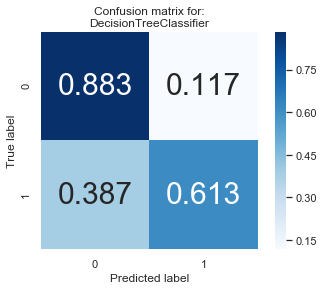

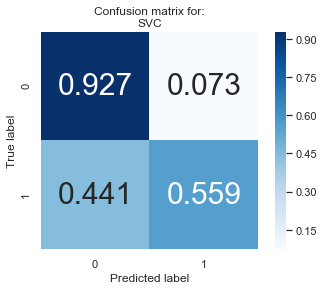

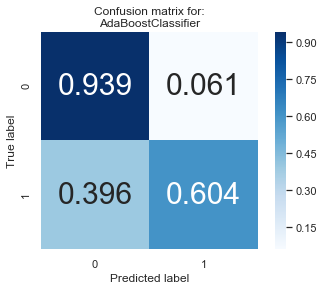

In [26]:
#Visualizing the confusion matrix for each classifier
from sklearn.metrics import confusion_matrix

for i,model in enumerate([clf_A,clf_B,clf_C]):
    cm = confusion_matrix(y_test, model.predict(X_test))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

    # view with a heatmap
    plt.figure(i)
    sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix for:\n{}'.format(model.__class__.__name__));

Looking at the results above, out of the three models, AdaBoost is the most appropriate for our task.

First and foremost, it is the classifier that performs the best on the testing data, in terms of both the accuracy and f-score. It also takes resonably low time to train on the full dataset, which is just a fraction of the 120 seconds taken by SVM, the next best classifier to train on the full training set. So it should scale well even if we have more data.

By default, Adaboost uses a decision stump i.e. a decision tree of depth 1 as its base classifier, which can handle categorical and numerical data. Weak learners are relatively faster to train, so the dataset size is not a problem for the algorithm.

#### But how does Adaboost work?
1. Adaboost works by combining several simple learners (for ex: decision trees), to create an ensemble of learners that can predict whether an individual earns above 50k or not.

2. Each of the learners, in our case decision trees, are created using "features" we have about individuals (eg. age, occupation, education, etc) create a set of rules that can predict a person's income.

3. During the training process, which lasts for several rounds, the Adaboost algorithm looks at instances where it has predicted badly, and prioritizes the correct prediction of those instances in the next round of training.

4. With each round, the model finds the best learner (or decision tree) to incorporate into the ensemble, repeating the process for the specified number of rounds, or till we can't improve the predictions further.

5. All the learners are then combined to make a final ensembled model, where they each vote to predict if a person earns more than 50k or not. Usually we take the majority of the votes to make a final prediction.

6. Using this model with the census information of individuals, we can predict the same information for a potential new donor and predict if they earn more than 50K or not, and thus make a decision on the likeliness of them donating to charity.

### Improving our Model: Model Tuning

Using grid search (GridSearchCV) with different parameter/value combinations, we can tune our model for even better results.

For Adaboost, we'll tune the n_estimators and learning rate parameters, and also the base classifier paramters (remember our base classifier for the Adaboost ensemble is a Decision tree!).



In [27]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

# Create the parameters list you wish to tune
parameters = {'n_estimators':[50, 120], 
              'learning_rate':[0.1, 0.5, 1.],
              'base_estimator__min_samples_split' : np.arange(2, 8, 2),
              'base_estimator__max_depth' : np.arange(1, 4, 1)
             }

# Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score,beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters,scorer)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train,y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print ("Unoptimized model\n------")
print ("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print ("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print ("\nOptimized Model\n------")
print ("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print ("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print (best_clf)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Unoptimized model
------
Accuracy score on testing data: 0.8373
F-score on testing data: 0.6682

Optimized Model
------
Final accuracy score on the testing data: 0.8702
Final F-score on the testing data: 0.7526
AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=6,
                                                     


### Final Model Evaluation

#### Results:


| Sno. |Metric | Benchmark Predictor | Unoptimized Model | Optimized Model |
| --- | --- | --- | --- | --- |
| 1 |Accuracy Score | 0.2478 | 0.8186 | 0.8702 |
| 2 |F-score | 0.2917 | 0.6282 | 0.7526 |


The optimized model has an accuracy of 0.8702 and F-score of 0.7526.
These scores are better than the umpotimized model, while being substantially better than the benchmark predictor.

### Extracting Feature Importance


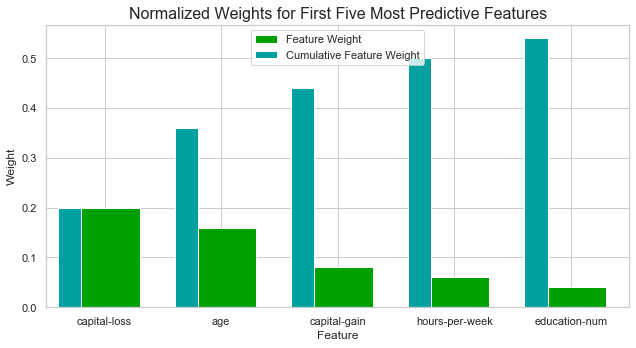

In [28]:
# Train the supervised model on the training set 
model = AdaBoostClassifier().fit(X_train,y_train)

# Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)


Of the five features predicted in the earlier section, 3 of them, Age, hours per week, education-num (which is a numerical label for education) are included in the list of features considered most important by Adaboost, although with different rankings.

I didn't consider two important features, capital-gain and capital-loss, partly due to my lack of understanding of what they meant. After researching what they mean (profit or loss from on the sale of assets/property), it makes sense for these features to be important. People who have earned profits from sale of assets are definitely likelier to earn higher, while those who incurred losses are likely to have had lower total income.

### Feature Selection
An interesting question here is, how does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of all features present in the data. This hints that we can attempt to reduce the feature space and simplify the information required for the model to learn.

Let's see how a model that is trained only on the selected features, performs.

In [29]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8702
F-score on testing data: 0.7526

Final Model trained on reduced data
------
Accuracy on testing data: 0.8437
F-score on testing data: 0.7065


### Effects of Feature Selection

On a reduced dataset, the final model's accuracy and f-score are still very comparable to the results on the full dataset.

The acccuracy is ~2.7% lower, while the f-score is ~5% lower. Even though Adaboost is relatively faster than one of the other classifiers that we tried out, I'd still consider training on the reduced data (acc. to features) if training time was a factor, and we have more training points to process. This decision will also depend on how important accuracy and f-scores are (or if f-score is more important than the accuracy, as the dip for that is larger than the dip in accuracy), to make a final decision regarding this.